# Calibration & Optimisation : CatBoost Hybride V1



In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ajout du dossier src au path
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.config import DATA_DIR, ARTIFACTS_DIR
from src.models.catboost.dataset import CatboostDatasetBuilder
from src.models.catboost.trainer import CatboostTrainer
from src.models.catboost.predictor import HybridPredictor
from src.pipelines.baseline_pipeline import BaselineArtifact
from src.baselines.conditional import ConditionalBaseline
from src.evaluation.evaluate_V2 import evaluate_masking

# Configuration visuelle
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Chargement & Préparation 


In [2]:
# Chargement
df_train = pd.read_csv(DATA_DIR / "Train.csv")

# Nettoyage Standard
def normalize_cat(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().str.casefold()

def apply_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in ["sex", "marital_status", "branch_code", "occupation_code", "occupation_category_code"]:
        out[c] = normalize_cat(out[c])
    jy = pd.to_numeric(out["join_date"].astype(str).str.split("/").str[-1], errors="coerce")
    out["join_year"] = jy.fillna(2017)
    out["age"] = (out["join_year"] - out["birth_year"]).clip(18, 90).fillna(38)
    return out

df_clean = apply_cleaning(df_train)

In [3]:
# Définition des colonnes
PROFILE_COLS = ["ID","join_date","sex","marital_status","birth_year","branch_code","occupation_code","occupation_category_code"]
PRODUCT_COLS = [c for c in df_train.columns if c not in PROFILE_COLS]
CAT_FEATURES = ["sex", "marital_status", "branch_code", "occupation_code", "occupation_category_code"]


In [4]:
# Split Train/Val
from sklearn.model_selection import train_test_split
ids_unique = df_clean["ID"].unique()
train_ids, val_ids = train_test_split(ids_unique, test_size=0.2, random_state=42)

df_local_train = df_clean[df_clean["ID"].isin(train_ids)].copy()
df_local_val = df_clean[df_clean["ID"].isin(val_ids)].copy().reset_index(drop=True)

# Construction du Dataset Supervisé
builder = CatboostDatasetBuilder(product_cols=PRODUCT_COLS, cat_cols=CAT_FEATURES, random_state=42)
print("Construction du dataset train...")
X_train, y_train = builder.build_dataset(df_local_train, strategy='smart', min_basket=2)
print(f"Dataset prêt : {X_train.shape}")

Construction du dataset train...
Dataset prêt : (23305, 29)


## 2. Phase A : Tuning Hyperparamètres (Depth)

Le paramètre le plus influent sur CatBoost après le `learning_rate` est la profondeur de l'arbre (`depth`).
- **Trop faible (<4)** : Le modèle est trop simple (High Bias, Underfitting).
- **Trop élevé (>8)** : Le modèle apprend par coeur le bruit (High Variance, Overfitting) et est très lent.

Nous allons tester `depth` dans `[4, 6, 8, 10]` avec un nombre d'itérations raisonnable (500) pour voir la tendance.

In [5]:
import itertools
import os
import pandas as pd

# Configuration de la Grille 
depths = [4, 6, 8]
learning_rates = [0.05, 0.1]
grid = list(itertools.product(depths, learning_rates)) # 6 combinaisons

# Fichier de sauvegarde pour ne rien perdre si ça plante
tuning_csv_path = ARTIFACTS_DIR / "tuning_results_grid.csv"

# --- Reprise sur panne ---
if tuning_csv_path.exists():
    df_results = pd.read_csv(tuning_csv_path)
    results_tuning = df_results.to_dict('records')
    # On identifie les couples déjà testés pour ne pas les refaire
    tested_configs = set(zip(df_results["depth"], df_results["learning_rate"]))
    print(f"Reprise du tuning : {len(tested_configs)} configurations déjà testées.")
else:
    results_tuning = []
    tested_configs = set()

# Données validation (format numpy pour rapidité)
X_val_full = df_local_val[PRODUCT_COLS].values

print(f"Lancement de la Grid Search sur {len(grid)} configurations...")

for d, lr in grid:
    # Si déjà fait, on saute
    if (d, lr) in tested_configs:
        print(f"Skipping (Depth={d}, LR={lr}) - Déjà fait.")
        continue
        
    print(f"\n>>> Test : Depth={d}, LR={lr} ...")
    
    # 1. Entraînement
    runner = CatboostTrainer(
        cat_features=CAT_FEATURES,
        iterations=500,
        learning_rate=lr,
        depth=d
    )
    runner.fit(X_train, y_train)
    
    # 2. Évaluation (Score Supervisé Pur)
    def temp_scorer(x_row, idx):
        ctx = df_local_val.iloc[[idx]].copy()
        ctx[PRODUCT_COLS] = x_row
        ctx = ctx[X_train.columns]
        return runner.predict_proba(ctx)[0]

    _, metrics = evaluate_masking(X_val_full, temp_scorer, hide_k=1, min_observed=1)
    
    score = metrics["Hit@1"]
    print(f"    -> Résultat : Hit@1 = {score:.4f}")
    
    # 3. Sauvegarde Immédiate
    results_tuning.append({
        "depth": d,
        "learning_rate": lr,
        "Hit@1": score,
        "Hit@3": metrics["Hit@3"]
    })
    pd.DataFrame(results_tuning).to_csv(tuning_csv_path, index=False)

# Affichage Bilan
df_results = pd.DataFrame(results_tuning).sort_values("Hit@1", ascending=False)
print("\n--- CLASSEMENT DES CONFIGURATIONS ---")
print(df_results)

Lancement de la Grid Search sur 6 configurations...

>>> Test : Depth=4, LR=0.05 ...
0:	learn: 0.7248659	total: 1.54s	remaining: 12m 50s
100:	learn: 0.8024458	total: 2m 20s	remaining: 9m 13s
200:	learn: 0.8239863	total: 4m 35s	remaining: 6m 49s
300:	learn: 0.8337696	total: 6m 52s	remaining: 4m 32s
400:	learn: 0.8384896	total: 9m 5s	remaining: 2m 14s
499:	learn: 0.8408067	total: 11m 11s	remaining: 0us
    -> Résultat : Hit@1 = 0.8558

>>> Test : Depth=4, LR=0.1 ...
0:	learn: 0.7248659	total: 1.45s	remaining: 12m 3s
100:	learn: 0.8248874	total: 2m 11s	remaining: 8m 38s
200:	learn: 0.8379747	total: 4m 21s	remaining: 6m 28s
300:	learn: 0.8429951	total: 6m 25s	remaining: 4m 14s
400:	learn: 0.8465565	total: 8m 27s	remaining: 2m 5s
499:	learn: 0.8494744	total: 10m 23s	remaining: 0us
    -> Résultat : Hit@1 = 0.8582

>>> Test : Depth=6, LR=0.05 ...
0:	learn: 0.7385540	total: 2.82s	remaining: 23m 27s
100:	learn: 0.8211972	total: 4m 17s	remaining: 16m 56s
200:	learn: 0.8367303	total: 9m 25s	rema

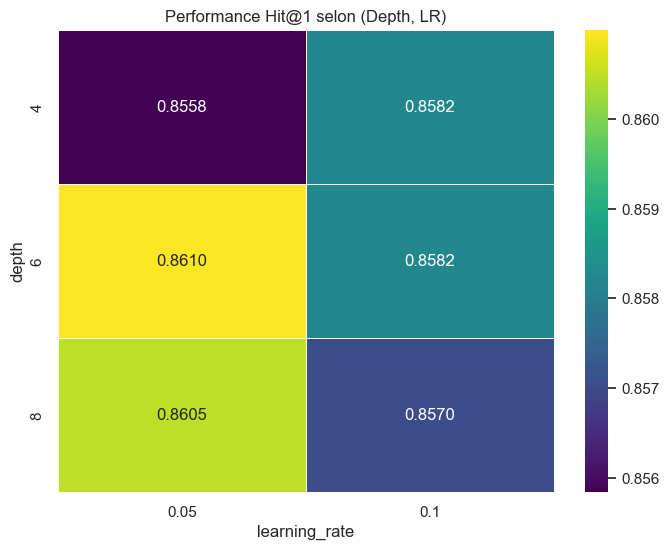

In [6]:
# Visualisation (Heatmap)
pivot_table = df_results.pivot(index="depth", columns="learning_rate", values="Hit@1")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis", linewidths=.5)
plt.title("Performance Hit@1 selon (Depth, LR)")
plt.show()

### Choix du Meilleur Modèle


In [7]:
# Sélection automatique du CHAMPION (Le 1er du classement)
best_row = df_results.iloc[0] 
best_depth = int(best_row["depth"])
best_lr = float(best_row["learning_rate"])

print(f"CONFIGURATION GAGNANTE : Depth={best_depth}, LR={best_lr}")
print("   (C'est cette config qui sera utilisée pour la suite)")



CONFIGURATION GAGNANTE : Depth=6, LR=0.05
   (C'est cette config qui sera utilisée pour la suite)


In [8]:
# Ré-entraînement propre du modèle 'Champion'
print("Ré-entraînement du modèle final...")
best_trainer = CatboostTrainer(
    cat_features=CAT_FEATURES,
    iterations=500,
    learning_rate=best_lr,
    depth=best_depth
)
best_trainer.fit(X_train, y_train)
print("Modèle Champion prêt.")

Ré-entraînement du modèle final...
0:	learn: 0.7385540	total: 3.2s	remaining: 26m 37s
100:	learn: 0.8211972	total: 4m 51s	remaining: 19m 10s
200:	learn: 0.8367303	total: 10m 9s	remaining: 15m 6s
300:	learn: 0.8452693	total: 14m 53s	remaining: 9m 51s
400:	learn: 0.8505471	total: 20m	remaining: 4m 56s
499:	learn: 0.8544947	total: 25m 11s	remaining: 0us
Modèle Champion prêt.


In [9]:
# Sauvegarde Finale du Modèle Champion
champion_save_path = ARTIFACTS_DIR / "catboost_champion_v1.cbm"
best_trainer.save(champion_save_path)
print(f"Modèle Champion sauvegardé dans : {champion_save_path}")
print("Tu pourras le charger plus tard avec trainer.load() sans ré-entraîner.")

Modèle Champion sauvegardé dans : C:\Users\gouab\Desktop\Projet_perso\insurance_recommender\Insurance_product_recommender\artifacts\catboost_champion_v1.cbm
Tu pourras le charger plus tard avec trainer.load() sans ré-entraîner.


In [ ]:
# Sauvegarder la version triée finale dans le CSV
df_results.to_csv(tuning_csv_path, index=False)

## 3. Phase B : Calibrage Hybride (Alpha)

Maintenant que nous avons le meilleur modèle supervisé possible, nous allons chercher le **point d'équilibre parfait** avec la Baseline.
- `alpha` faible (ex: 0.1) : On fait confiance au CatBoost.
- `alpha` fort (ex: 0.9) : On fait confiance à la statistique (Baseline).

On teste de 0.0 à 1.0. **C'est très rapide** car on n'a pas besoin de rée-entraîner, juste de combiner les probabilités différemment.

In [11]:
# 1. Charger la Baseline (nécessaire pour le modèle hybride)
baseline_art = BaselineArtifact.load(ARTIFACTS_DIR / "baseline_v0")

# 2. Créer le Predictor Hybride avec ton champion tout neuf (best_trainer)
hybrid_model = HybridPredictor(best_trainer, baseline_art)

# 3. Grille d'Alpha
alphas_to_test = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results_alpha = []
alpha_csv_path = ARTIFACTS_DIR / "tuning_results_alpha.csv"

print("Lancement de la calibration Alpha...")

for a in alphas_to_test:
    # Définition scorer dynamique
    def hybrid_scorer_alpha(x_row, idx):
        ctx = df_local_val.iloc[[idx]].copy()
        # On injecte les produits observés
        ctx[PRODUCT_COLS] = x_row
        # On filtre les colonnes pour n'avoir que celles de l'entraînement
        ctx = ctx[X_train.columns]
        return hybrid_model.predict_proba(ctx, alpha=a)[0]

    _, m = evaluate_masking(X_val_full, hybrid_scorer_alpha, hide_k=1, min_observed=1)
    
    res = {"alpha": a, "Hit@1": m["Hit@1"], "Hit@3": m["Hit@3"]}
    results_alpha.append(res)
    print(f"   Alpha={a} -> Hit@1={m['Hit@1']:.4f}")
    
    # SAUVEGARDE IMMEDIATE
    pd.DataFrame(results_alpha).to_csv(alpha_csv_path, index=False)

df_alpha = pd.DataFrame(results_alpha)

Lancement de la calibration Alpha...
   Alpha=0.0 -> Hit@1=0.8610
   Alpha=0.1 -> Hit@1=0.8636
   Alpha=0.2 -> Hit@1=0.8641
   Alpha=0.3 -> Hit@1=0.8656
   Alpha=0.4 -> Hit@1=0.8651
   Alpha=0.5 -> Hit@1=0.8667
   Alpha=0.6 -> Hit@1=0.8668
   Alpha=0.7 -> Hit@1=0.8687
   Alpha=0.8 -> Hit@1=0.8713
   Alpha=0.9 -> Hit@1=0.8708
   Alpha=1.0 -> Hit@1=0.8716


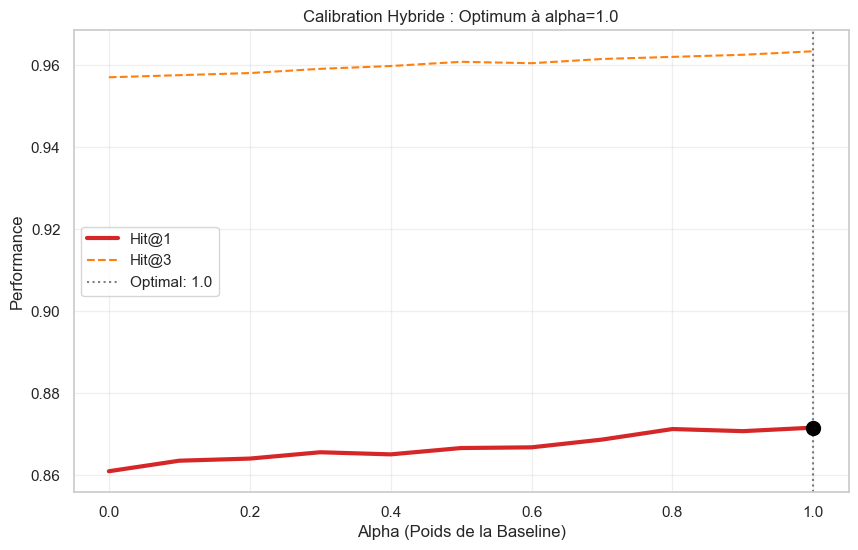

In [12]:
# Visualisation Calibration
plt.figure(figsize=(10, 6))
plt.plot(df_alpha["alpha"], df_alpha["Hit@1"], color="#d62728", linewidth=3, label="Hit@1")
plt.plot(df_alpha["alpha"], df_alpha["Hit@3"], color="#ff7f0e", linestyle="--", label="Hit@3")

# Zone optimale
best_alpha_idx = df_alpha["Hit@1"].idxmax()
best_alpha = df_alpha.loc[best_alpha_idx, "alpha"]
max_score = df_alpha.loc[best_alpha_idx, "Hit@1"]

plt.axvline(best_alpha, color='black', linestyle=':', alpha=0.5, label=f"Optimal: {best_alpha}")
plt.scatter([best_alpha], [max_score], s=100, c='black', zorder=5)

plt.xlabel("Alpha (Poids de la Baseline)")
plt.ylabel("Performance")
plt.title(f"Calibration Hybride : Optimum à alpha={best_alpha}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
import json

# Résumé de la configuration gagnante
final_config = {
    "best_depth": best_depth,
    "best_learning_rate": best_lr,
    "best_alpha": float(best_alpha), # Convertir en float python standard
    "iterations": 500,
    "Hit@1_max": float(max_score)
}

print("Configuration Optimale Finale :")
print(json.dumps(final_config, indent=4))

# Sauvegarde de la config
config_path = ARTIFACTS_DIR / "best_config_v1.json"
with open(config_path, "w") as f:
    json.dump(final_config, f, indent=4)
    
print(f"Configuration sauvegardée dans : {config_path}")

Configuration Optimale Finale :
{
    "best_depth": 6,
    "best_learning_rate": 0.05,
    "best_alpha": 1.0,
    "iterations": 500,
    "Hit@1_max": 0.8716320576626051
}
Configuration sauvegardée dans : C:\Users\gouab\Desktop\Projet_perso\insurance_recommender\Insurance_product_recommender\artifacts\best_config_v1.json


## 4. Phase C : Analyse Approfondie (Feature Selection)

Regardons si toutes les variables servent vraiment. Souvent, enlever les variables inutiles (> 1% importance) stabilise le modèle.

C:\Users\gouab\AppData\Local\Temp\ipykernel_4904\3601036471.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importances", y="Feature Id", data=fi.head(20), palette="viridis")


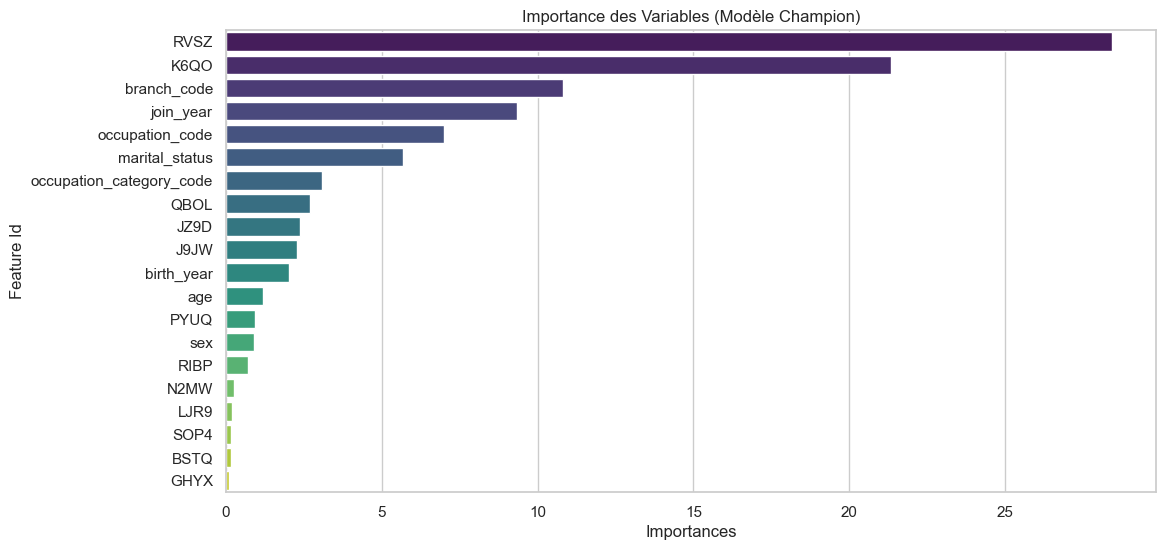


Variables potentiellement inutiles (17) :
['PYUQ', 'sex', 'RIBP', 'N2MW', 'LJR9', 'SOP4', 'BSTQ', 'GHYX', 'AHXO', '66FJ', 'ECY3', 'FM3X', '8NN1', '7POT', 'P5DA', 'GYSR', 'JWFN']


In [20]:
fi = best_trainer.model.get_feature_importance(prettified=True)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x="Importances", y="Feature Id", data=fi.head(20), palette="viridis")
plt.title("Importance des Variables (Modèle Champion)")
plt.show()

# Affichage des variables inutiles (< 1%)
useless_features = fi[fi["Importances"] < 1.0]
print(f"\nVariables potentiellement inutiles ({len(useless_features)}) :")
print(useless_features["Feature Id"].tolist())

In [19]:
fi["Importances"]

0     28.433319
1     21.358526
2     10.812929
3      9.335808
4      6.979873
5      5.667928
6      3.069242
7      2.679196
8      2.363344
9      2.273489
10     2.018359
11     1.189128
12     0.941134
13     0.884392
14     0.715546
15     0.248057
16     0.187163
17     0.159665
18     0.157074
19     0.106953
20     0.105985
21     0.083179
22     0.077227
23     0.074381
24     0.043403
25     0.034700
26     0.000000
27     0.000000
28     0.000000
Name: Importances, dtype: float64

In [ ]:
"""# Sauvegarde Finale du Meilleur Modèle Optimisé
final_save_path = ARTIFACTS_DIR / "catboost_optimized_v1.cbm"
best_trainer.save(final_save_path)
print(f"Modèle optimisé sauvegardé dans : {final_save_path}")"""